In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

%matplotlib inline

$$
\newcommand{\R}{\mathbf{R}}
\newcommand{\r}{\mathbf{r}}
\newcommand{\F}{\mathbf{F}}
\newcommand{\V}{\mathbf{V}}
\newcommand{\ntickers}{{n_\text{tickers}}}
\newcommand{\ndates}{{n_\text{dates}}}
\newcommand{\nfactors}{{n_\text{factors}}}
\newcommand{\nchars}{{n_\text{chars}}}
\newcommand{\dp}{{(d)}}
\newcommand{\sp}{{(s)}}
\newcommand{\Bbeta}{\mathbf\beta}
$$

# Factor models via Autoencoders

A clever way of using Neural Networks to solve a familiar but important problem in Finance
was proposed by [Gu, Kelly, and Xiu, 2019](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3335536).

It is an extension of the Factor Model framework of Finance, combined with the tools of
dimensionality reduction (to find the factors) of Deep Learning: the Autoencoder.

You can find [code](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/20_autoencoders_for_conditional_risk_factors/06_conditional_autoencoder_for_asset_pricing_model.ipynb)
for this model as part of the excellent book by [Stefan Jansen](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/20_autoencoders_for_conditional_risk_factors/06_conditional_autoencoder_for_asset_pricing_model.ipynb)
- [Github](https://github.com/stefan-jansen/machine-learning-for-trading)
- In order to run the code notebook, you first need to run a notebook for [data preparation](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/20_autoencoders_for_conditional_risk_factors/05_conditional_autoencoder_for_asset_pricing_data.ipynb)
    - This notebook relies on files created by notebooks from earlier chapters of the book
    - So, if you want to run the code, you have a lot of preparatory work ahead of you
    - Try to take away the ideas and the coding

# Factor Model review

We will begin with a quick review/introduction to Factor Models in Finance.

The universe of securities (e.g., equities) is often quite large
- several hundred (or thousands) of individual tickers
- denote the size by $n$

It is often the case that the returns of many securities can be explained
- as being the sum of influences of "common factors"
    - market index
    - industry indices
    - size, momentum


It is sometimes useful to *approximate* the return of a security
- as the dot product of
- the sensitivity of the security to a number $f$ of *common factors*
- the returns of the common factors

This is useful
- as a means of *dimensionality* reduction
    - we need timeseries of returns for only $f \le n$ factors rather than all $n$ securities
- as a means of understanding the behavior of two or more securities
    - as the sum of common influences
    - rather than completely idiosyncratic returns
    - Hedging, risk-management

First, some necessary notation:
- $\r^{(d)}_s$: Return of ticker $s$ on day $d$.
- $\hat\r^{(d)}_s$: approximation of $\r^{(d)}_s$

- $n_\text{tickers}$: **large** number of tickers
- $n_\text{dates}$: number of dates
- $n_\text{factors}$: **small** number of factors: independent variables (features) in our approximation
- Matrix $\R$ of ticker returns, indexed by *date*
    - $\R: (n_\text{dates} \times n_\text{tickers})$
    - $| \R^\dp | = n_\text{tickers}$
        - $\R^\dp$ is vector of returns for each of the $\ntickers$ on date $d$

- $\r$ will denote a vector of single day returns: $\R^\dp$ for some date $d$

**Notation summary**

term &nbsp; &nbsp;  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| meaning
:---|:---
$s$ | ticker
$\ntickers$ | number of tickers
$d$ | date
$\ndates$ | number of dates
$\nchars$   | number of characteristics per ticker
$m$ | number of examples
    | $m = \ndates$
$i$ | index of example
    | There will be one example per date, so we use $i$ and $d$ interchangeably.
$ [ \X^\ip, \R^\ip ]$ | example $i$
         | $| \X^\ip | = (\ntickers \times  \nchars )$ 
         | $| \R^\ip | = \ntickers$
$\X^\dp_s$ | vector of ticker $s$'s characteristics on day $d$
             | $ | \X^\dp_s | = \nchars$


**Note**

The paper actually seeks to predict $\hat\r^{(d+1)}_s$ (forward return) rather than approximate
the current return $\hat\r^\dp_s$.

We will present this as an approximation problem as opposed to a prediction problem for
simplicity of presentation (i.e., to include PCA as a model).

A **factor model** seeks to approximate/explain the return of a *number* of tickers in terms of common "factors" $\F$
- $\F: (\ndates \times \nfactors)$
$$
\begin{array} \\
\R^\dp_1 & = & \Bbeta^\dp_1 \cdot \F^\dp  + \epsilon_1\\
\vdots \\
\R^\dp_\ntickers & = & \Bbeta^\dp_\ntickers \cdot \F^\dp + \epsilon_\ntickers \\
\end{array}
$$



There are several ways to create a factor model
- depending on what we assume
- is given, in addition to $\R$

We will examine each method, but here is a high-level summary:

$$
\begin{array} \\
\textbf{Name} &\textbf{Given} & \textbf{Solve for} & \textbf{Equation} &\textbf{Method} \\
\text{Pre-defined factors} & \F: (\ndates \times \nfactors) & \beta_s: (\nfactors) & \R_s^T =  \F * \beta_s & \text{timeseries regression}\\
& & &  \text{for each ticker } s \\
\text{Pre-defined sensitivities} &\beta: (\ntickers \times \nfactors) & \F^\dp & \R^\dp = \beta * \F^\dp & \text{cross-sectional regression} \\
& & &  \text{for each date } d \\
\text{Nothing pre-defined} & & \F, \beta^T & \R = \F * \beta^T & \text{Principal Components} \\
\text{AE for cond. risk factors} & & \F^\dp, \underline\beta^\dp: (\ntickers \times \nfactors) & & \text{AE-like Neural Network} \\
& &  \text{time-varying } \underline\beta: (\ntickers \times \nfactors \times \ndates) \\
\end{array}
$$

The first two approaches
- take one part (e.g., sensitivities or factor returns) of the product as given
- solves for the other part

The PCA approach
- solves for *both* parts of the product
    - subject to the ticker sensitivities $\beta$ being fixed through time
    
The Autoencoder for Conditional Risk factors approach
- solves for *both* parts of the product
    - **and** has time-varying sensitivities $\beta$ and factor returns $\F$

## Pre-defined factors, solve for sensitivities

Suppose $\F$ is given: a matrix of returns of "factors" over a range of dates
- $\F^\dp$ includes the returns of multiple factor tickers
    - e.g., market, several industries, large/small cap indices
    
Solve for $\Bbeta_s$, for each $s$
- $\ntickers$ separate Linear Regression models
- Linear regression for ticker $s$:
    - $r_s$ and $\F$ are time series (length $\ndates$) of returns for tickers/factors
    - Solve for $\Bbeta_s$
        - constant over time
        $$\beta_s^\dp = \beta_s$$
    - $\langle \X^\dp, \y^\dp \rangle = \langle  \F^\dp, \r^\dp_s \rangle$
    
$$
\r_s = \begin{pmatrix}
 \r_s^{(1)} \\
 \r_s^{(2)} \\
  \vdots  \\
 \r_s^{(\ndates)}
  \end{pmatrix}, \,\,
\F = \begin{pmatrix}
 \F_1^{(1)} & \ldots & \F_\nfactors^{(1)}\\
 \F_1^{(2)} & \ldots & \F_\nfactors^{(2)} \\
  \vdots  \\
 \F_1^{(\ndates)} & \ldots & \F_\nfactors^{(\ndates)}
  \end{pmatrix}, \, \,
\beta_s = \begin{pmatrix}
\beta_{s,1} \\
\beta_{s,2} \\
\vdots \\
\beta_{s, \nfactors}
\end{pmatrix}
$$
<br>
$$\r_s = \F * \beta_s$$


   

### Picture of linear regression

- One ticker $s$ at a time, as a timeseries
    - selected column in left matrix
- *Given*
    - matrix  $\F$ of factor timeseries
        - columns of right matrix
- *Solve*
    - for sensitivities $\Bbeta_s$ (middle vector)
    - dot product of sensitivity vector and *row* of factors on *one date(
        - estimated returns
            $$\hat\r_s^\dp = \Bbeta_s \cdot \F^\dp$$
            
Linear regression solves for $\Bbeta_s$
- to minimize errors *across dates*
$$\sum_{d=1}^\ndates {  \left( \r_s^\dp  - \hat\r_s^\dp \right)^2}$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create sample data for both matrices
dates = ['2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05']
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
factors = ['Factor1', 'Factor2', 'Factor3']

# Matrix 1: Tickers
data_tickers = np.zeros((len(dates), len(tickers)))
googl_index = tickers.index('GOOGL')
data_tickers[:, googl_index] = np.random.rand(len(dates))

# Matrix 2: Factors
data_factors = np.zeros((len(dates), len(factors)))

# Sensitivities vector
sensitivities = np.zeros((1, len(factors)))

# Create the plot with three subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), 
                                    gridspec_kw={'width_ratios': [len(tickers), len(factors), len(factors)]})

# Function to create heatmap with consistent cell size
def plot_heatmap(ax, data, xlabels, ylabels, title):
    im = ax.imshow(data, cmap='Greys', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(ylabels)
    ax.set_xlabel(xlabels.name)
    ax.set_ylabel(ylabels.name)
    ax.set_title(title, fontsize=14)
    
    # Thicker grid lines
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)

    # Set minor ticks for grid lines
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    
    return im

# Plot the first heatmap (Tickers)
plot_heatmap(ax1, data_tickers, pd.Index(tickers, name='Tickers'), pd.Index(dates, name='Dates'), 
             "Dates and Tickers\n(GOOGL highlighted)")

# Plot the sensitivities vector
im2 = ax2.imshow(sensitivities, cmap='Greys', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(np.arange(len(factors)))
ax2.set_xticklabels(factors, rotation=45, ha="right", rotation_mode="anchor")
ax2.set_yticks([0])
ax2.set_yticklabels(['Sensitivities'])
ax2.set_xlabel('Factors')
ax2.set_title('Sensitivities', fontsize=14)

# Thicker grid lines for sensitivities vector
ax2.grid(which="minor", color="black", linestyle='-', linewidth=3)

# Set minor ticks for grid lines
ax2.set_xticks(np.arange(sensitivities.shape[1]+1)-.5, minor=True)
ax2.set_yticks(np.arange(sensitivities.shape[0]+1)-.5, minor=True)

# Add "?" to each cell of the sensitivities vector with larger size and red color
for i in range(len(factors)):
    ax2.text(i, 0, "?", ha='center', va='center', fontsize=20, color='red')  # Increased fontsize and set color to red

# Plot the second heatmap (Factors)
plot_heatmap(ax3, data_factors, pd.Index(factors, name='Factors'), pd.Index(dates, name='Dates'), 
             "Dates and Factors")

# Adjust layout
plt.tight_layout()

# Add some space between subplots
plt.subplots_adjust(wspace=0.3)

# Adjust the height of ax2 to match one row of the other matrices
ax2_pos = ax2.get_position()
ax3_pos = ax3.get_position()
new_height = (ax3_pos.y1 - ax3_pos.y0) / len(dates)
ax2.set_position([ax2_pos.x0, ax3_pos.y1 - new_height, ax2_pos.width, new_height])

# plt.show()
plt.close(fig)

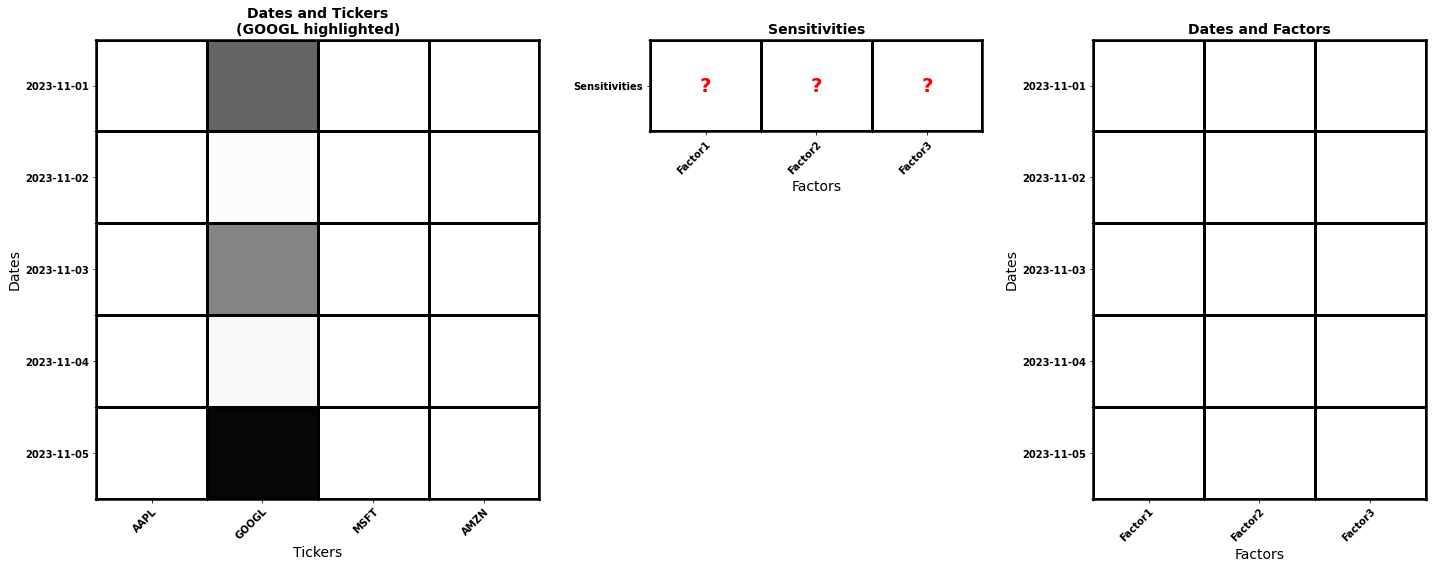

In [3]:
fig

## Pre-defined sensitivities, solve for factors

Suppose $\Bbeta$ is given: 
- for each ticker $s$: $\Bbeta_{s, j}$ is the sensitivity of $s$ to $\F_j$

Solve for $\F^\dp$ for each $d$

- $\ndates$ separate Linear Regressions
- Linear regression for date $d$
    - $\r^\dp$ and $\beta^\dp$ are *cross sections* (width $\ntickers$) of one day ticker returns/sensitivities
    - Solve for $\F^\dp$
        - constant over tickers
        $$\F_s^\dp = \F^\dp$$
    - $\langle \X^\sp, \y^\sp \rangle = \langle \Bbeta^\sp, \r^\sp \rangle$
 
$$
\r^\dp = \begin{pmatrix}
 \r^\dp_1 \\
 \r^\dp_1 \\
  \vdots  \\
 \r^\dp_\ntickers
  \end{pmatrix}, \,\,
\F^\dp = \begin{pmatrix}
 \F^\dp_1  \\
 \F^\dp_2  \\
  \vdots  \\
 \F^\dp_\nfactors
  \end{pmatrix}, \, \,
\Bbeta = \begin{pmatrix}
\beta_{1,1}, & \ldots & \beta_{1, \nfactors} \\
\beta_{2,1}, & \ldots  &\beta_{2, \nfactors} \\
\vdots \\
\beta_{\ntickers,1}, & \ldots & \beta_{\ntickers, \nfactors} \\
\end{pmatrix}
$$
<br>
$$\r^\dp = \Bbeta * \F^\dp$$  

### Picture of Cross-Sectional regression

- One date $d$ at a time
    - selected row of left matrix
- *Given*
    - matrix $\Bbeta$ of sensitivities of each ticker to each factor
    $$\Bbeta: (\ntickers \times \nfactors)$$

    - sensitivities are *constant* through time
- *Solve*
    - for factor returns at one date
        - selected row of right matrix
     - dot product of 
         - sensitivity for one ticker (e.g., red row for AAPL)  
         - factor returns at date $d$
     - give estimated return of AAPL
         $$\hat\r_\text{AAPL} = \Bbeta^\text{AAPL} \cdot \F^\dp$$
         
 
Cross-sectional regression solves for $\F^\dp$
- to minimize errors *across tickers*
$$\sum_{s=1}^\ntickers{  \left( \r_s^\dp  - \hat\r_s^\dp \right)^2}$$

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create sample data for all matrices
dates = ['2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05']
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
factors = ['Factor1', 'Factor2', 'Factor3']

# Choose a row to highlight (let's say the third row, index 2)
highlight_row = 2

# Matrix 1: Dates and Tickers
data_tickers = np.zeros((len(dates), len(tickers)))
data_tickers[highlight_row, :] = np.random.rand(len(tickers))

# Matrix 2: Tickers and Sensitivities
data_sensitivities = np.zeros((len(tickers), len(factors)))

# Matrix 3: Dates and Factors
data_factors = np.zeros((len(dates), len(factors)))
data_factors[highlight_row, :] = np.random.rand(len(factors))

# Create the plot with three subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), 
                                    gridspec_kw={'width_ratios': [len(tickers), len(factors), len(factors)]})

# Function to create heatmap with consistent cell size
def plot_heatmap(ax, data, xlabels, ylabels, title):
    im = ax.imshow(data, cmap='Greys', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_xticklabels(xlabels, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(ylabels)
    ax.set_xlabel(xlabels.name)
    ax.set_ylabel(ylabels.name)
    ax.set_title(title, fontsize=14)

    # Thicker grid lines
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)

    # Set minor ticks for grid lines
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)

    return im

# Plot the first heatmap (Dates and Tickers) with highlighted row
plot_heatmap(ax1, data_tickers, pd.Index(tickers, name='Tickers'), pd.Index(dates, name='Dates'), 
             f"Dates and Tickers\n(Row {highlight_row + 1} highlighted)")

# Plot the middle matrix (Tickers and Sensitivities) without highlighting
im2 = plot_heatmap(ax2, data_sensitivities, pd.Index(factors, name='Factors'), pd.Index(tickers, name='Tickers'), 
                   "Tickers and Sensitivities")

# Color the row labeled GOOGL blue in the middle matrix
googl_index = tickers.index('GOOGL')
ax2.add_patch(plt.Rectangle((-0.5, googl_index - 0.5), len(factors), 1,
                             color='blue', alpha=0.5))

aapl_index = tickers.index('AAPL')
ax2.add_patch(plt.Rectangle((-0.5, aapl_index - 0.5), len(factors), 1,
                             color='red', alpha=0.5))

msft_index = tickers.index('MSFT')
ax2.add_patch(plt.Rectangle((-0.5, msft_index - 0.5), len(factors), 1,
                             color='olive', alpha=0.5))


amzn_index = tickers.index('AMZN')
ax2.add_patch(plt.Rectangle((-0.5, amzn_index - 0.5), len(factors), 1,
                             color='orange', alpha=0.5))


# Assign similar colors to the selected row of the first matrix
# Color AAPL cell red and AMZN cell orange
ax1.add_patch(plt.Rectangle((googl_index - 0.5, highlight_row - 0.5), 1, 1,
                             color='blue', alpha=0.5))

ax1.add_patch(plt.Rectangle((aapl_index - 0.5, highlight_row - 0.5), 1, 1,
                             color='red', alpha=0.5))

ax1.add_patch(plt.Rectangle((msft_index - 0.5, highlight_row - 0.5), 1, 1,
                             color='olive', alpha=0.5))

ax1.add_patch(plt.Rectangle((amzn_index - 0.5, highlight_row - 0.5), 1, 1,
                             color='orange', alpha=0.5))

# Plot the third heatmap (Dates and Factors)
plot_heatmap(ax3, data_factors, pd.Index(factors, name='Factors'), pd.Index(dates, name='Dates'), 
             f"Dates and Factors\n(Row {highlight_row + 1} highlighted)")

# Add large red "?" in each cell of the selected row in the third matrix
for i in range(len(factors)):
    ax3.text(i, highlight_row, "?", ha='center', va='center', fontsize=30, color='red')

# Adjust the aspect ratio of the middle plot to match row heights
ax2.set_aspect(len(factors) * len(dates) / (len(tickers) * len(tickers)))

# Adjust layout
plt.tight_layout()

# Add some space between subplots
plt.subplots_adjust(wspace=0.3)

# plt.show()
plt.close(fig)

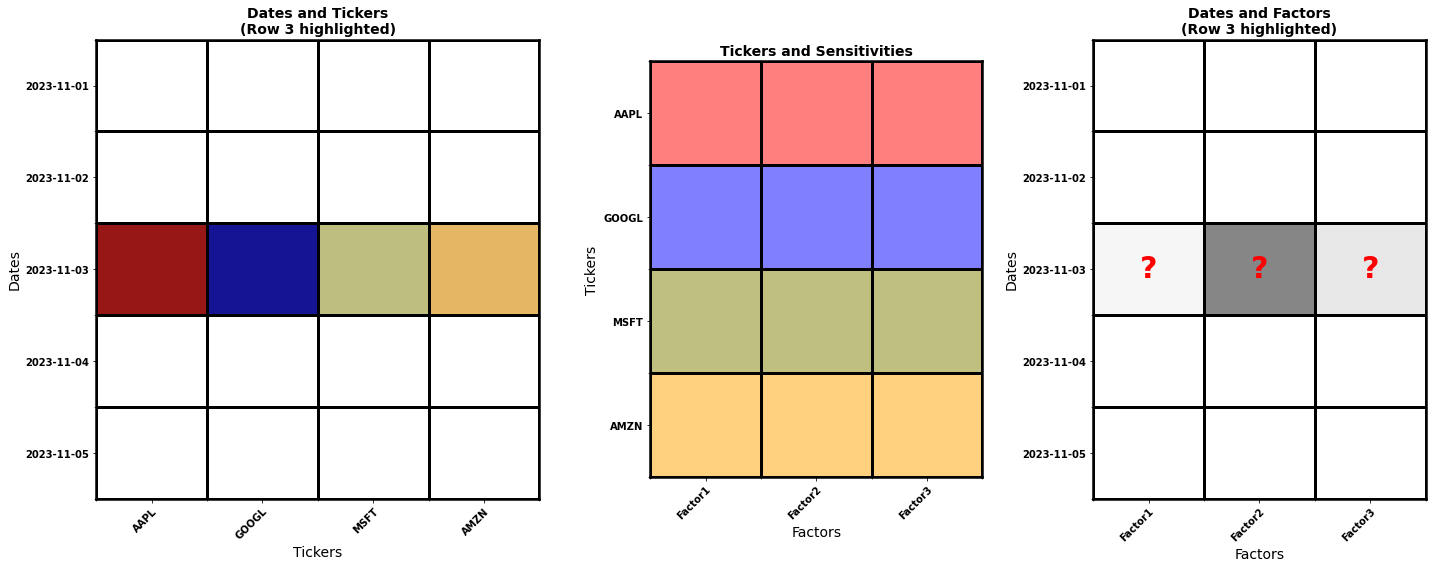

In [5]:
fig

## Solve for sensitivities and factors: PCA

Yet another possibility: solve for $\Bbeta$ and $\F$ *simulataneoulsy*.

Recall Principal Components
- Representing $\X$ (defined relative to $\ntickers$ "standard" basis vectors) via an *alternate basis* $\V$
$$\X = \tilde\X \V^T$$

We factor matrix $\X$ into $\tilde\X$ and $\V^T$.

In our case, we identify
- $\X$ with the ticker returns $\R$.
- $\tilde\X$ with the factor returns $\F$
- $\V^T$ as $\beta$

Thus
$$
\R = \tilde\R \beta
$$

where
$$
\begin{array} \\
\R, \tilde\R: (\ndates \times n_\text{tickers}) \\
\beta: (n_\text{tickers} \times n_\text{tickers} ) \\
\end{array}
$$

The factorization is often used to achieve *dimensionality reduction*
- approximating the $n_\text{tickers}$ timeseries
- with $n_\text{factors}\lt n_\text{tickers}$ factors

Reducing the dimension yields an approximation of $\R$
$$
\R \approx \F \beta
$$

where
$$
\begin{array} \\
\R: (\ndates \times n_\text{tickers}) \\
\F: (\ndates \times \nfactors) \\
\beta: (\nfactors \times n_\text{tickers} ) \\
\end{array}
$$

Thus
- column $j$ of $\F$ is the return series of the $j^{th}$ factor
- column $j$ of $\beta$ are the sensitivities of ticker $i$ to the factors
    - which *don't* vary with time

The return $\R^\dp_j$ of ticker $j$ on date $d$ is approximated by
- the dot product of row $d$ of $F$
    - the returns of the $\nfactors$ on date $d$
- and column $j$ of $\beta$
    - the sensitivities of $j$ to the $\nfactors$


# This paper

This paper will create a factor model that
- Solve for $\F, \Bbeta$ simultaneously
    - like PCA
    - but with time-varying $\Bbeta$
    
This very general approach is facilitated because
- $\F$ and $\Bbeta$ are defined by Neural Networks

<table>
    <tr>
        <th><center>Autoencoder Asset Model</center></th>
    </tr>
    <tr>
        <td><img src="images/autoencoder_asset_model.png">
          </td>
    </tr>
   
</table>

## Autoencoder

The paper refers to the model as a kind of Autoencoder.

<table>
    <tr>
        <th><center>Autoencoder</center></th>
    </tr>
    <tr>
        <td><img src="images/Autoencoder_vanilla.png"></td>
    </tr>
</table>

Let's review the topic.
- An Autoencoder has two parts: an Encoder and a Decoder
- The Encoder maps inputs $\x^\ip$, of length $n$
- Into a "latent vectors" $\z^\ip$ of length $n' \le n$
- If $n' \lt n$, the latent vector is a *bottleneck*
    - reduced dimension representation of $\x^\ip$
- The Decoder maps $\z^\ip$ into $\hat\x^\ip$, of length $n$, that is an approximation of $\x^\ip$
    

The training examples for an Autoencoder are
$$\langle \X^\dp, \y^\dp \rangle = \langle \R^\dp, \R^\dp \rangle$$

That is
- we want the output for each example to be identical to the input

The challenge:
- the input is passed through a "bottleneck" $\z$ of lower dimensions than the example length $n$
- information is lost
- analog: using PCA for dimensionality reduction, but with non-linear operations

## Autoencoder for Conditional Risk Factors

Imagine that we are given $\R: (\ndates \times \ntickers)$
- timeseries (length $\ndates$) of returns of $\ntickers$ tickers

Suppose we  map a one day set of returns $\R^\dp$ into two separate values
- $\Bbeta^\dp: (\ntickers \times \nfactors)$ -- the sensitivity of each ticker to each of $\nfactors$ one day "factor" returns
- $\F^\dp: (\nfactors \times 1)$ -- the one day returns of $\nfactors$ factors

Our goal is to output $\hat\R^\dp$, an approximations of $\R^\dp$ such that
$$
\begin{array} \\
\hat\R^\dp & = & \beta^\dp * \F^\dp \\
\hat\R^\dp & \approx & \R^\dp \\
\end{array}
$$

This is the same goal as an Autoencoder but subject to the constraint that $\hat\R^\dp$
- is the product of the ticker sensitivities and factor returns

The Neural Network *simultaneously* solves for $\Bbeta^\dp$ and $\F^\dp$.

This looks somewhat like PCA
- **but**, in PCA,  $\Bbeta$ does not vary by day: it is constant over days
- in this model, $\Bbeta^\dp$ varies by day


This paper goes one step further than the standard Autoencoder
- Inputs $\X: (\ndates \times \ntickers \times \nchars)$ 
- rather than $\R: (\ndates \times \ntickers)$

Each ticker $s$ on each day $d$, has $\nchars \ge 1$ "characteristic"
- one of them may the daily return $\R^\dp$
- but may also include a number of other time varying characteristics


The proposed model is a Neural Network with two sub-networks.

The *Beta network* computes $\Bbeta^\dp_s =  \text{NN}_\Bbeta( \X^\dp_s ; \W_\Bbeta )$
- $\X_s^\dp$ as input
- parameterized by weights $\W_\beta$
- $\Bbeta_s^\dp$ is only a function of $\X^\dp_s$, the characteristics of $s$
    - and **not** of any other ticker $s' \ne s$
    - $\Bbeta^\dp_s$ shares $\W_\Bbeta$ across **all** tickers $s'$ and dates $d'$
    - contrast this with factor model with fixed factors
        - we solve for a separate $\Bbeta_s$ for each ticker $s$
        - via per-ticker timeseries regression
    - contrast this with PCA
        - $\beta_s$ is influenced by $\R_{s'}$ for $s' \ne s$

The *Factor network* computes $\F^\dp = \text{NN}_\F(\R^\dp, \W_\F)$
- $\R^\dp$ as input (not $\X^\dp$ as in the Beta network)
- parameterized by weights $\W_\F$
$\R^\dp$ is only a function of $\R^\dp$ for date $d$
    - and **not** of any other date $d' \ne d$
    - $\F^\dp$ shares $\W_\F$ across **all** dates

This model
- has *neither* pre-defined Factors $\F$ or pre-defined Sensitivities $\beta$
- Simultaneously solve for $\Bbeta^\dp_s$ and $\F^\dp$

Here is a picture

<table>
    <tr>
        <th><center>Autoencoder for Conditional Risk Factors</center></th>
    </tr>
    <tr>
        <td><img src="images/Autoencoder_for_conditional_risk_factors.png" width="90%"></td>
    </tr>
</table>


## Summary of this paper

Approximate cross section of daily returns:  $\hat\r^\dp \approx \r^\dp$
$$\r^\dp \approx \hat\r^\dp = \Bbeta^\dp * \F^\dp $$

- like an Autoencoder
- subject 
    - to returns as product of sensitivities and factors: $\hat\r^\dp = \Bbeta^\dp * \F^\dp$
    - $\Bbeta^\dp_s =  \text{NN}_\Bbeta( \X^\dp_s ; \W_\Bbeta )$
    -  $\F^\dp = \text{NN}_\F(\R^\dp, \W_\F)$

Shapes:
- $\r^\dp: (n_\text{tickers} \times 1)$
- $\Bbeta: (n_\text{tickers} \times n_\text{factors})$
- $\F^\dp: (n_\text{factors} \times 1)$



# Complete Neural Network

## Beta (Input) side of network

The Beta network $\text{NN}_\beta$
- maps *ticker characteristics* to *ticker factor sensitivities*
    - **for each day**
    

It uses a single layer fully connected (Dense) Layer with $\nfactors$ units
- input: $\nchars$ attributes (characteristics) for each of $\ntickers$ tickers
- output: $\nfactors$ factor sensitivities for each of $\ntickers$ tickers

$$
\text{NN}_\beta : (\ntickers \times \nchars) \mapsto (\ntickers \times \nfactors)
$$

### Input $\X$

$
\X : ( \ndates \times \ntickers \times \nchars )
$

$\X^\dp :  (\ntickers \times \nchars)$
- Example on date $d$
- Consists of $\ntickers$ tickers, each with $\nchars$ characteristics

### Sub Neural network $\text{NN}_\Bbeta$

$\text{NN}_\Bbeta = $ `Dense` $( \nfactors )( \X )$
- Fully connected network
- `Dense` $( \nfactors )$ computes a function $(\ntickers \times \nchars) \mapsto (\ntickers \times \nfactors) $
- Threads over ticker dimension ([see](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense))
    - tickers share same weights across **all** tickers
    - single `Dense` $( \nfactors )$ **not** $\ntickers$ copies of `Dense`$( \nfactors )$ with independent weights

$\W_\beta: ( \nfactors \times \nchars )$
- weights shared across all $d, s$
    - $\W^\dp_{\beta, s} = \W^{(d')}_{\Bbeta, s'}$ for all $s', d'$
    - the transformation of characteristics to beta *independent* of ticker 
- hence, size of $\W_\beta$ is $( \nfactors \times \nchars )$

$$
\Bbeta^\dp = \text{Dense} \,( \nfactors, \text{activation='relu'} ) ( \X^\dp )
$$

$$ \Bbeta^\dp : ( \ntickers \times \nfactors )$$

**Note** that the Beta network
- uses non-linearities (ReLU activation for the `Dense`  hidden layer)
- more complex relationship 
    - translating the "characteristics" (given as input) of a ticker
    - to its betas with respect to the constructed factors

## Factor side of network

The Factor network $\text{NN}_F$
- maps *ticker returns* to *factor returns* 
    - **for each day**

It uses a single layer fully connected (Dense) Layer with $\nfactors$ units
- input: vector of ticker returns (one-day)
- output: vector of factor returns

$$
\text{NN}_\F: \ntickers \mapsto \nfactors
$$

### Input $\R$

$
\R : ( \ndates \times \ntickers )
$

$\R^\dp:  (\ntickers \times 1)$
- Example on date $d$
- Consists of returns of $\ntickers$ tickers

### Sub  Neural network $\text{NN}_\F$

$\text{NN}_\F = $ `Dense` $( \nfactors )$
- Fully connected network
- `Dense`( $\nfactors )$ computes a function $\ntickers \mapsto \nfactors$

$\W_\F: (\nfactors \times \ntickers )$
- Weights shared across all $d, s$
    - $\W^\dp_{\F, s} = \W^{(d')}_{\F, s'}$ for all $s', d'$
    - the transformation of cross section of ticker returns to Factor returns *independent* of ticker 
- hence, size of $\W_\F$ is $( \ntickers \times \nfactors)$


$$
\F^{(d)} = \text{Dense} \,( n_\text{factors} ) ( \R^{(d)} )
$$

$$  \F^{(d)} : \nfactors$$

**Note** that the Factor Network
- **does not** use non-linearities (no activation function in the `Dense` layer)
- design choice
    - factors are thus linear combinations of the input series
    - so can construct the factors as portfolios of the input series
        - with quantities give by weights of the `Dense` network

## Dot

The `Dot` layer computes the dot product of tickers sensitivities and factor returns.
- this is the predicted return

$$\hat{\r}^\dp = \Bbeta^\dp \cdot \F^\dp$$

Dot product threads over factor dimension
- Computes $\hat\r^\dp_s = \Bbeta_s^\dp \cdot \F^\dp$ for each $s$
    - each $s$ is a row of $\Bbeta^\dp$

$$ \hat{\r}^\dp :  \ntickers $$

# Loss

The key to any NN is the Loss Function.

Let
$\loss^\dp_{(s)}$ denote error of ticker $s$ on day $d$.
$$
\loss^\dp_{(s)} = \r^\dp_s - \hat{\r}^\dp_s
$$

$\loss^\dp$ is the loss, across tickers, on date $d$ (one training example)

$$
\loss^\dp = \sum_s { \loss^\dp_{(s)} }
$$

The number of examples $m$ equals $\ndates$

So the Total Loss is
$$
\loss = \sum_d { \loss^\dp }
$$


# Predicting future returns, rather than explaining contemporaneous returns

The model is sometimes presented as predicting **day ahead** returns rather than contemporaneous returns.

In that case the objective is
$$
\hat\r^\dp = \r^{(d + 1)}
$$
and Loss for a single ticker and date becomes

$$
\loss^\dp_\sp = \r^{(d+1)}_s - \hat{\r}^\dp_s
$$


# Code

The model is built by the function [`make_model`](06_conditional_autoencoder_for_asset_pricing_model.ipynb#Automate-model-generation)

    def make_model(hidden_units=8, n_factors=3):
        input_beta = Input((n_tickers, n_characteristics), name='input_beta')
        input_factor = Input((n_tickers,), name='input_factor')

        hidden_layer = Dense(units=hidden_units, activation='relu', name='hidden_layer')(input_beta)
        batch_norm = BatchNormalization(name='batch_norm')(hidden_layer)

        output_beta = Dense(units=n_factors, name='output_beta')(batch_norm)

        output_factor = Dense(units=n_factors, name='output_factor')(input_factor)

        output = Dot(axes=(2,1), name='output_layer')([output_beta, output_factor])

        model = Model(inputs=[input_beta, input_factor], outputs=output)
        model.compile(loss='mse', optimizer='adam')
        return model
        

Here is what the model looks like:

<img src="images/autoencoder_factor_model.png">

Highlights
- **Two** input layers
    - one each for the Beta and Factor networks
- The model is passed a **pair** as input
    - one input for each side of the network
    
           Model(inputs=[input_beta, input_factor], outputs=output)
 
     - and is [called](06_conditional_autoencoder_for_asset_pricing_model.ipynb#Train-Model) with a pair
     
             model.fit([X1_train, X2_train], y_train,
                 ...
- Loss function: MSE

        model.compile(loss='mse', optimizer='adam')

Training data

    def get_train_valid_data(data, train_idx, val_idx):
        train, val = data.iloc[train_idx], data.iloc[val_idx]
        X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
        X1_val = val.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
        X2_train = train.loc[:, 'returns'].unstack('ticker')
        X2_val = val.loc[:, 'returns'].unstack('ticker')
        y_train = train.returns_fwd.unstack('ticker')
        y_val = val.returns_fwd.unstack('ticker')
        return X1_train, X2_train, y_train, X1_val, X2_val, y_val
        
- `X1_train`: ticker chacteristics

        X1_train = train.loc[:, characteristics].values.reshape(-1, n_tickers, n_characteristics)
        
- `X2_train`: ticker returns
    - Dataframe attribute `returns`

            X2_train = train.loc[:, 'returns'].unstack('ticker')
        
- `y_train`: *forward* ticker returns
    - Dataframe attribute `returns_fwd`

            y_train = train.returns_fwd.unstack('ticker')
        

# Discussion

## Comparison to other factor models

Recall the pre-defined sensitivities factor model
- given sensitivities of tickers to factors
- solve for factors

The sensitivities were not time-varying
- but the cross-sectional regression would trivially accept time-varying sensitivities
- as does the Autoencoder (time-varying "characteristics" per ticker)

The Autoencoder model is most similar to the pre-defined sensitivities model.

The main difference
- pre-defined sensitivities are with respect to factors whose "meaning" has been pre-defined
    - e.g., a "size" or "industry" factor
    - the cross-sectional regression solves for a factor with a *pre-defined* meaning
- Autoencoder model has sensitivities to "characteristics" rather than factors with pre-defined meaning
    - we *solve* for betas with respect to *implied* factors
        - and simultaneously solve for the factor returns
    - the "meaning" of the factors is **not** pre-defined
        - is a function of characteristics
        - determined by weights of the Beta network

Also note that the depth of the Beta network could be greater
- non-linearities at each layer
- more complex relationships

In contrast, the Factor network
- is constructed as a single layer with no activations
- in order to make construction of "factor portfolios" possible

The inputs to the Factor network could be *any* timeseries
- does not have to be the ticker returns
- e.g., liquid, investable instruments such as ETF's

In [6]:
print("Done")

Done
